# Importing necessary packages

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants(simulation paramaters)

In [58]:
'''
The simulation parameters:

launch_height : intial height above ground in meters
launch_speed :  intial speed of the ball in meters/second.
launch_angle : intial angle of the ball in degrees. 
gravity : Acceleration due to gravity in meters/seond^2

'''

launch_height = 20 
launch_speed = 25   
launch_angle = 25
gravity = 9.81  

# Convert launch angle to radians using the np.radians built in function.
launch_angle_rad = np.radians(launch_angle)

# Calculating the intial velocity component in x and y directions
x0 = 0
y0 = launch_height
vx0 = launch_speed * np.cos(launch_angle_rad)
vy0 = launch_speed * np.sin(launch_angle_rad)


# Intialisation

In [59]:


# Time step and total simulation time
dt = 0.1  # Time step in seconds (the time span between two observations)
total_time = 5  # Total_time in seconds
time_steps = int(total_time / dt) #Number of time steps

# Initialize arrays to store the true positions of the ball
true_positions = np.zeros((time_steps, 2))
true_positions[0] = [x0, y0] #intial position
true_velocities = np.zeros((time_steps,2))
true_velocities[0] = [vx0,vy0]

# Initialize arrays to store observed positions(true positions with noise) of the ball
observed_positions = np.zeros((time_steps, 2))
observed_positions[0] = [x0, y0] #intial position


# Simulating the trajectory of ball

In [60]:
''' 
Simulate the trajectory of the ball:

Calculating the true positions and observed positions:
True positions are calculated using the projectile motion equations.
The observed positions should be erroneous positions over time. So, adding a noise to the true positions will make
it incorrect.
'''

for t in range(1, time_steps):
    # Update true positions
    true_positions[t, 0] = x0 + vx0 * (t*dt)  # x(t) = x0 + vx0 * t
    true_positions[t, 1] = y0 + vy0 * (t*dt) - 0.5 * gravity * (t*dt)**2  # y(t) = y0 + vy0 * t - 0.5 * g * t^2

    true_velocities[t,0] = vx0
    true_velocities[t,1] = vy0 - gravity *(t*dt)
    
    # Add noise to observations
    observed_positions[t, 0] = true_positions[t, 0] + np.random.normal(0, 1)
    observed_positions[t, 1] = true_positions[t, 1] + np.random.normal(0, 1)

  
    # Stop the simulation if the ball hits the ground
    if true_positions[t, 1] <= 0:
        true_positions[t, 1] = 0
        observed_positions[t, 1] = 0
        observed_positions = observed_positions[:t+1]
        break
    
def remove_zero_rows(data):
    # Check if all elements in a row are zero
    return [row for row in data if not all(element == 0 for element in row)]

true_velocities_cleaned = remove_zero_rows(true_velocities)
true_velocities_cleaned = np.array(true_velocities_cleaned)
#print(observed_positions)
true_positions_cleaned = remove_zero_rows(true_positions)
true_positions_cleaned = np.array(true_positions_cleaned)
observed_positions_cleaned = remove_zero_rows(observed_positions)
observed_positions_cleaned = np.array(observed_positions_cleaned)
    

# dropping some observations out completely over time intervals

In [61]:
def replace_with_none_over_interval(matrix, time_intervals):
    '''
    A function to replace values with None on specific time intervals
    
    Parameters:
    matrix(list of lists) : a 2D list of lists where the values are replaced with None
    time_intervals(lst of tuples) : time intervals
    
    returns
    A list of lists where the values in the time intervals are replaced with 'None' value
    '''
    for start_time, end_time in time_intervals:
        for i in range(len(matrix)):
            t = i * dt
            if start_time <= t <= end_time:
                matrix[i] = [None, None]
    return matrix

# Define time intervals to replace values with None
time_intervals = [(1, 1.5), (3, 3.5)]

# Replace values with None over the specified time intervals
observed_positions_cleaned = replace_with_none_over_interval(observed_positions_cleaned, time_intervals)


# Kalman filter implementation

In [62]:
# Kalman Filter Implementation to get predicted observations:
'''Intial Parameters of Kalman filter:
               
                A - State tranisition matrix
                H - Observation matrix
                Q - process noise covariance matrix (keeps the covariance matrix from not becoming too small or zero)
                R - Measurement covariance matrix (error in the measurement)
                x - Initial state estimate [x_position, y_position, x_velocity, y_velocity]
                p - Intial error covariance matrix
     
'''
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

Q = np.eye(4)  
R = np.array([[1, 0],
              [0, 1]])

x = np.array([x0, y0, vx0, vy0])
P = np.eye(4) * 500

#Kalman filter function.
def kalman_filter(z, x, P): 
    '''Calculating the kalman equations:
       Function returns : the updated state matrix and covariance matrix '''
    
    x_pred = A @ x  #predict the next step
    P_pred = A @ P @ A.T + Q #predict the next covariance matrix
    
    if z is not None and not np.any(np.isnan(z)):
        #update step
        y = z - (H @ x_pred)
        S = H @ P_pred @ H.T + R 
        K = P_pred @ H.T @ np.linalg.inv(S)   #kalman gain calculation
    
        x_update = x_pred + K @ y #Update the state estimate
        P_update = (np.eye(4) - K @ H) @ P_pred # Update the error covariance
    else:
        x_update = x_pred
        P_update = P_pred
    
    return x_update, P_update


# Run the Kalman Filter function on observed positions to get predicted observations.
estimated_positions = []
estimated_velocities = []
for z in observed_positions_cleaned:
    if z[0] is None or z[1] is None:
        x, P = kalman_filter(None, x, P)
    else:
        x, P = kalman_filter(z, x, P)
    estimated_positions.append(x[:2])  # Append only the first two values (x and y)
    estimated_velocities.append(x[2:4]) # Append only the last two values (x0 and y0)
    

estimated_positions = np.array(estimated_positions) #converting estimated positions to numpy array() to plot.

estimated_velocities = np.array(estimated_velocities) #converting estimated velocities to numpy array() to plot.


# Plotting the results

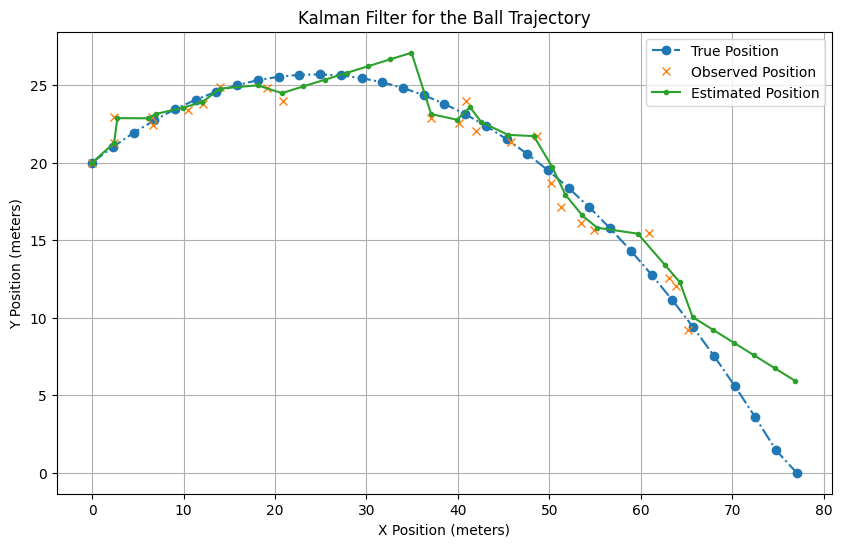

In [66]:
# Plotting the results using matplotlib
# plotting the true positions, observed positions and estimated positions 

plt.figure(figsize=(10, 6))
plt.plot(true_positions_cleaned[:, 0], true_positions_cleaned[:, 1], label='True Position', linestyle='-.', marker='o')
plt.plot(observed_positions_cleaned[:, 0], observed_positions_cleaned[:, 1], label='Observed Position', linestyle='none', marker='x')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label='Estimated Position', linestyle='-', marker='.')
plt.legend()
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('Kalman Filter for the Ball Trajectory')
plt.grid(True)
plt.show()

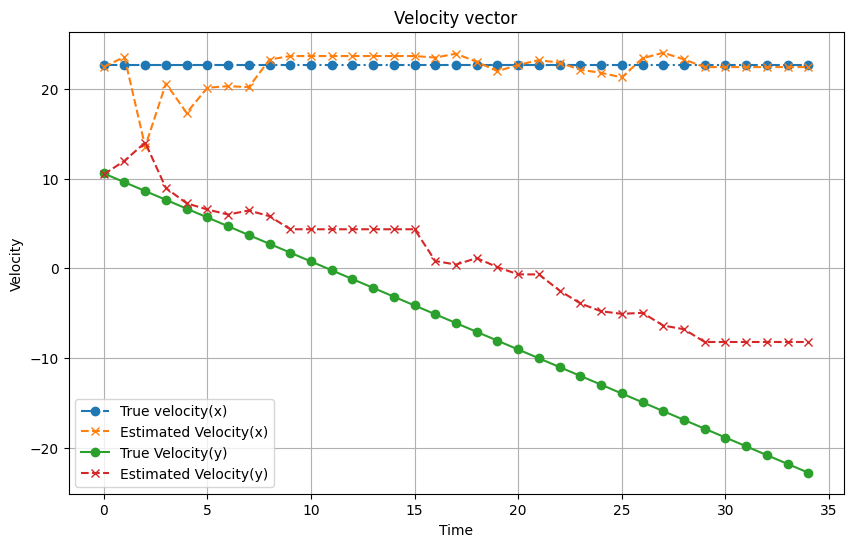

In [68]:
# Plotting the results using matplotlib
# plotting the true velocities, and estimated velocities 

plt.figure(figsize=(10, 6))
plt.plot(range(len(estimated_velocities)), true_velocities_cleaned[:, 0], label='True velocity(x)', linestyle='-.', marker='o')
plt.plot(range(len(estimated_velocities)), estimated_velocities[:, 0], label='Estimated Velocity(x)', linestyle='--', marker='x')
plt.plot(range(len(estimated_velocities)), true_velocities_cleaned[:, 1], label='True Velocity(y)', linestyle='-', marker='o')
plt.plot(range(len(estimated_velocities)), estimated_velocities[:, 1], label='Estimated Velocity(y)', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vector')
plt.grid(True)
plt.show()